<a href="https://www.kaggle.com/code/nabeelparuk/framingham-heart-study-predictive-model?scriptVersionId=195808845" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

****

# Framingham Heart Study Predictive Model

*Created by Nabeel Paruk*

Link to dataset: https://www.kaggle.com/datasets/shreyjain601/framingham-heart-study

Link to dataset description: https://search.r-project.org/CRAN/refmans/riskCommunicator/html/framingham.html

****

# Introduction

The human heart is a vital organ that has many factors that can affect its functioning. The Framingham Heart Study was conducted in Framingham, Massachusetts and is a landmark study in cardiovascular health as it considered not only multiple factors that could affect the heart, but their long-term effects and their interactions. Participant clinic data was collected during three examination periods, approximately 6 years apart, from roughly 1956 to 1968. This project aims to determine whether a patient will live or die based on the data collected in the study. Analysis of the data was conducted and three models applied to it: XGboost Classifier, Random Forest Classifier and a Logistic Regression model. We performed hyperparameter optimisation using Bayesian Hyperparameter Optimisation, with HyperOpt and evaluated the model using ROC curves and computing the area under the curves. We assessed feature importance using SHAPley explanations.

****

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/framingham-heart-study/Framingham Dataset.csv


**Import Useful Modules**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import shap

from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score

import time

import warnings
warnings.filterwarnings('ignore')

Import data

In [3]:
full_data = pd.read_csv("/kaggle/input/framingham-heart-study/Framingham Dataset.csv")

****

# Exploratory Data Analysis

*Data was sourced from Kaggle*

In [4]:
print(full_data.columns)

Index(['RANDID', 'SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE',
       'CIGPDAY', 'BMI', 'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ',
       'PREVCHD', 'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD',
       'HDLC', 'LDLC', 'DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD',
       'STROKE', 'CVD', 'HYPERTEN', 'TIMEAP', 'TIMEMI', 'TIMEMIFC', 'TIMECHD',
       'TIMESTRK', 'TIMECVD', 'TIMEDTH', 'TIMEHYP'],
      dtype='object')


In [5]:
missing_rows = full_data.isnull().sum()
missing_cells = missing_rows.sum()
print("Total missing cells: ", missing_cells)

total_cells = np.product(full_data.shape)
print("Total cells: ", total_cells)

percent_missing = (missing_cells / total_cells) * 100
print("Percent missing cells:", round((percent_missing), 2), end="%")


Total missing cells:  20075
Total cells:  453453
Percent missing cells: 4.43%

In [6]:
# Change SEX column to be binary data

full_data.SEX.replace(1, 0, inplace=True)
full_data.SEX.replace(2, 1, inplace=True)
full_data.tail()

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,CVD,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP
11622,9998212,0,173.0,46,126.0,82.0,0,0.0,19.17,0,...,0,1,8766,8766,8766,8766,8766,8766,8766,0
11623,9998212,0,153.0,52,143.0,89.0,0,0.0,25.74,0,...,0,1,8766,8766,8766,8766,8766,8766,8766,0
11624,9999312,1,196.0,39,133.0,86.0,1,30.0,20.91,0,...,0,1,8766,8766,8766,8766,8766,8766,8766,4201
11625,9999312,1,240.0,46,138.0,79.0,1,20.0,26.39,0,...,0,1,8766,8766,8766,8766,8766,8766,8766,4201
11626,9999312,1,NaN,50,147.0,96.0,1,10.0,24.19,0,...,0,1,8766,8766,8766,8766,8766,8766,8766,4201


In [7]:
full_data.isnull().sum()

RANDID         0
SEX            0
TOTCHOL      409
AGE            0
SYSBP          0
DIABP          0
CURSMOKE       0
CIGPDAY       79
BMI           52
DIABETES       0
BPMEDS       593
HEARTRTE       6
GLUCOSE     1440
educ         295
PREVCHD        0
PREVAP         0
PREVMI         0
PREVSTRK       0
PREVHYP        0
TIME           0
PERIOD         0
HDLC        8600
LDLC        8601
DEATH          0
ANGINA         0
HOSPMI         0
MI_FCHD        0
ANYCHD         0
STROKE         0
CVD            0
HYPERTEN       0
TIMEAP         0
TIMEMI         0
TIMEMIFC       0
TIMECHD        0
TIMESTRK       0
TIMECVD        0
TIMEDTH        0
TIMEHYP        0
dtype: int64

**Determining correlation will help us eliminate data redundancy and data leakage**

In [8]:
corr_df = full_data.drop(["RANDID", "DEATH"], axis=1)
corr_df.head()

,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,BPMEDS,...,CVD,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP
0,0,195.0,39,106.0,70.0,0,0.0,26.97,0,0.0,...,1,0,8766,6438,6438,6438,8766,6438,8766,8766
1,0,209.0,52,121.0,66.0,0,0.0,NaN,0,0.0,...,1,0,8766,6438,6438,6438,8766,6438,8766,8766
2,1,250.0,46,121.0,81.0,0,0.0,28.73,0,0.0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766
3,1,260.0,52,105.0,69.5,0,0.0,29.43,0,0.0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766
4,1,237.0,58,108.0,66.0,0,0.0,28.50,0,0.0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766


In [9]:
cor = corr_df.corr(method='pearson')

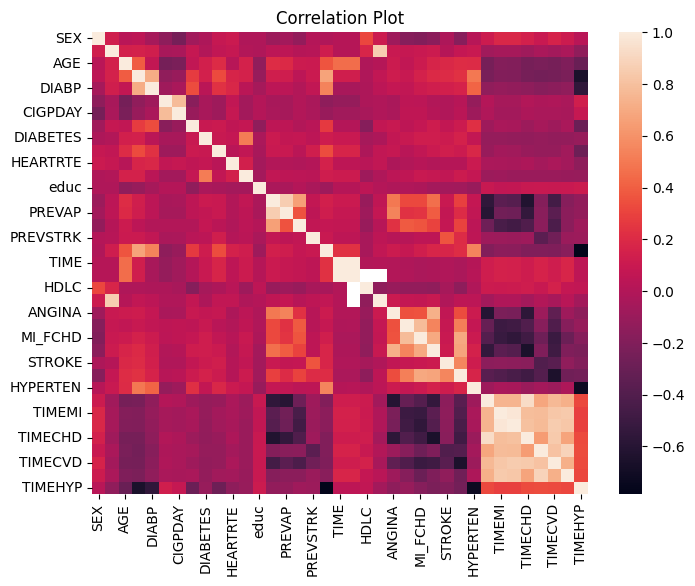

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor)
plt.show()

Can see there is high correlation among the time features as well as many missing values in HDLC / LDLC (seen earlier) -> Remove them

There were also some variables that were related e.g. PREVAP and PRECHD

In [11]:
# Choose features

excl_features = ["RANDID", "HDLC", "LDLC", "DEATH", "TIMEDTH", "TIMEMI", "TIMESTRK", "TIMEAP", "TIMEMIFC", "TIMECHD", "TIMECVD", "TIMEHYP", "TIME", "CVD", "PREVAP", "CURSMOKE", "ANGINA", "HOSPMI", "MI_FCHD", "SYSBP", "PREVMI", "PREVHYP", "DIABETES"]

In [12]:
# Drop unwanted features

X = full_data.copy()
X.drop(excl_features, axis=1, inplace=True)

y = full_data.DEATH

**Split Data**

In [13]:
X_init, X_test, y_init, y_test = train_test_split(X, y)
X_train, X_valid, y_train, y_valid = train_test_split(X_init, y_init)

In [14]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data_temp = train_data.reset_index(drop=True)

target = ["DEATH"]
predictors = [x for x in train_data.columns if x not in [target]]

**Recheck correlation matrix**

In [15]:
corr_2 = X_train.corr(method='pearson')

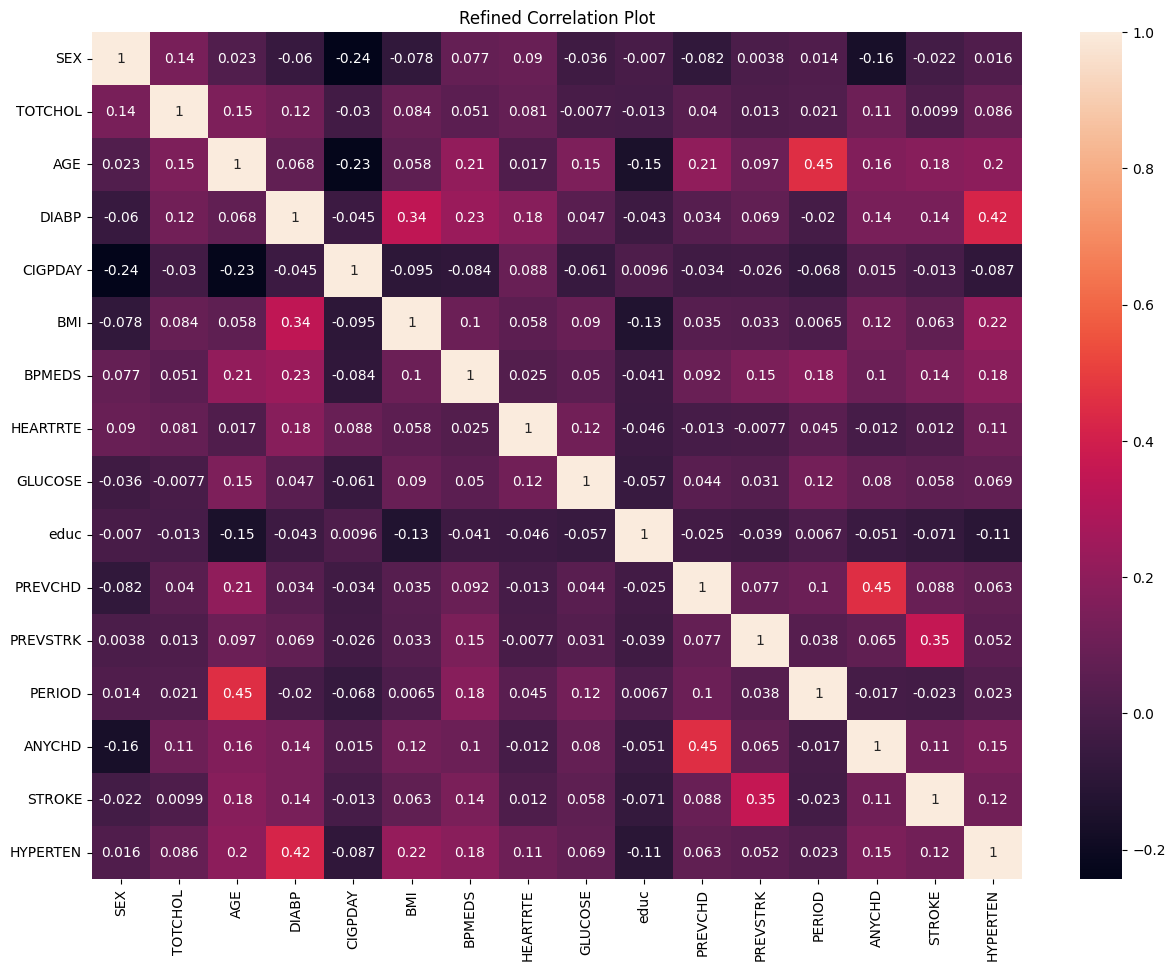

In [16]:
fig, ax = plt.subplots(figsize=(15,11))
plt.title("Refined Correlation Plot")
sns.heatmap(corr_2, annot=True)
plt.show()

Don't see any real concerning correlations and thus low risk of data redundancy

### Visualisation

**Looking at key parameters of current data**

We have already eliminated our correlated variables to reduce the potential of data leakage and increase the possibility of determining feature importance. This section will be to gain a better intuition of the features left and how they interact with each other and the target variable. There are also slight correlations between some of the remaining features and it would be useful to infer why these features are showing relationships.

**Check how many patients survived**

In [17]:
n = len(train_data)
surv = len(train_data[train_data['DEATH']==0])
print("Count of survived patients:", surv)

died = len(train_data[train_data['DEATH']==1])
print("Count of deceased patients:", died)

Count of survived patients: 4580
Count of deceased patients: 1960


In [18]:
perc_surv = (surv / n) * 100
perc_died = (died / n) * 100

print("Percent survived:", round(perc_surv,2), end="%\n")
print("Percent died:", round(perc_died, 2), end="%")

Percent survived: 70.03%
Percent died: 29.97%

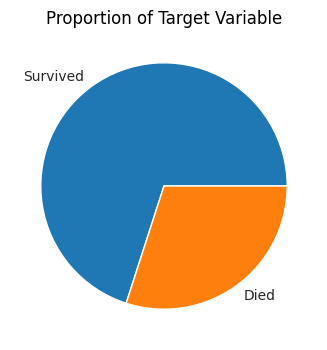

In [19]:
fig, ax = plt.subplots()
sns.set_style('whitegrid')
plt.pie([perc_surv, perc_died], labels=["Survived", "Died"])
plt.title("Proportion of Target Variable")
plt.show()

Cleary, majority of the patients survived. This shows that the classes are clearly imbalanced.

**Check ratio of Male vs Female**

In [20]:
male = len(train_data[train_data["SEX"]==0])
print("Count of male patients:", male)

female = len(train_data[train_data["SEX"]==1])
print("Count of female patients:", female)

Count of male patients: 2822
Count of female patients: 3718


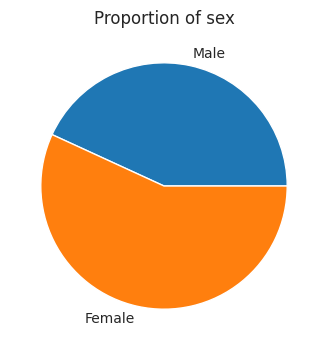

In [21]:
sns.set_style('whitegrid')
plt.figure()
plt.pie([male, female], labels=["Male", "Female"])
plt.title("Proportion of sex")
plt.show()

Check count of male and female patients that died/survived

In [22]:
# Format a new dataframe that has sex and death information

male_surv = len(train_data.loc[(train_data.SEX == 0) & (train_data.DEATH == 0)])
male_died = len(train_data.loc[(train_data.SEX == 0) & (train_data.DEATH == 1)])
female_surv = len(train_data.loc[(train_data.SEX == 1) & (train_data.DEATH == 0)])
female_died = len(train_data.loc[(train_data.SEX == 1) & (train_data.DEATH == 1)])
sex_death_df = pd.DataFrame(data=[[male_surv, male_died], [female_surv, female_died]], columns=["Survived", "Died"], index=["Male", "Female"])
sex_death_df = sex_death_df.reset_index()
sex_death_df.rename(columns={"index": "Sex"}, inplace=True)
sex_death_df_long = pd.melt(sex_death_df, id_vars="Sex", var_name="Result", value_name="Count")

<Figure size 1200x400 with 0 Axes>

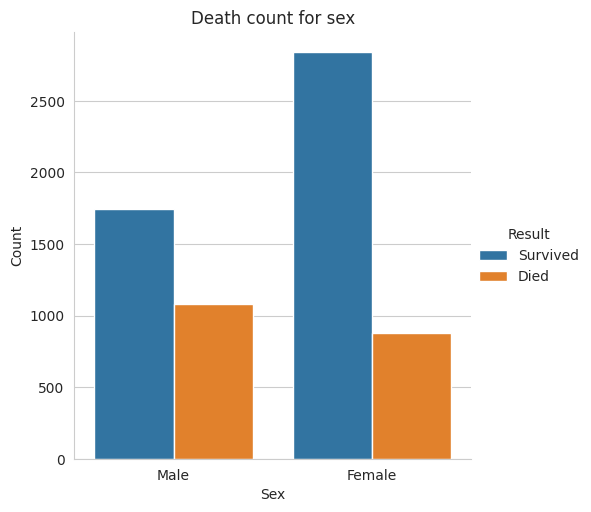

In [23]:
plt.figure()
sns.catplot(data=sex_death_df_long, x="Sex", y="Count", hue="Result", kind='bar')
plt.title("Death count for sex")
plt.show()

**Age in relation to Glucose, Body Mass Index and Heart Rate**

In [24]:
# Create dataframe with these factors and the target variable only
hist_df = full_data[['AGE', 'GLUCOSE', 'BMI', 'HEARTRTE', "DEATH"]]
hist_df["DEATH"].replace([0,1],["Survived", "Died"], inplace=True)

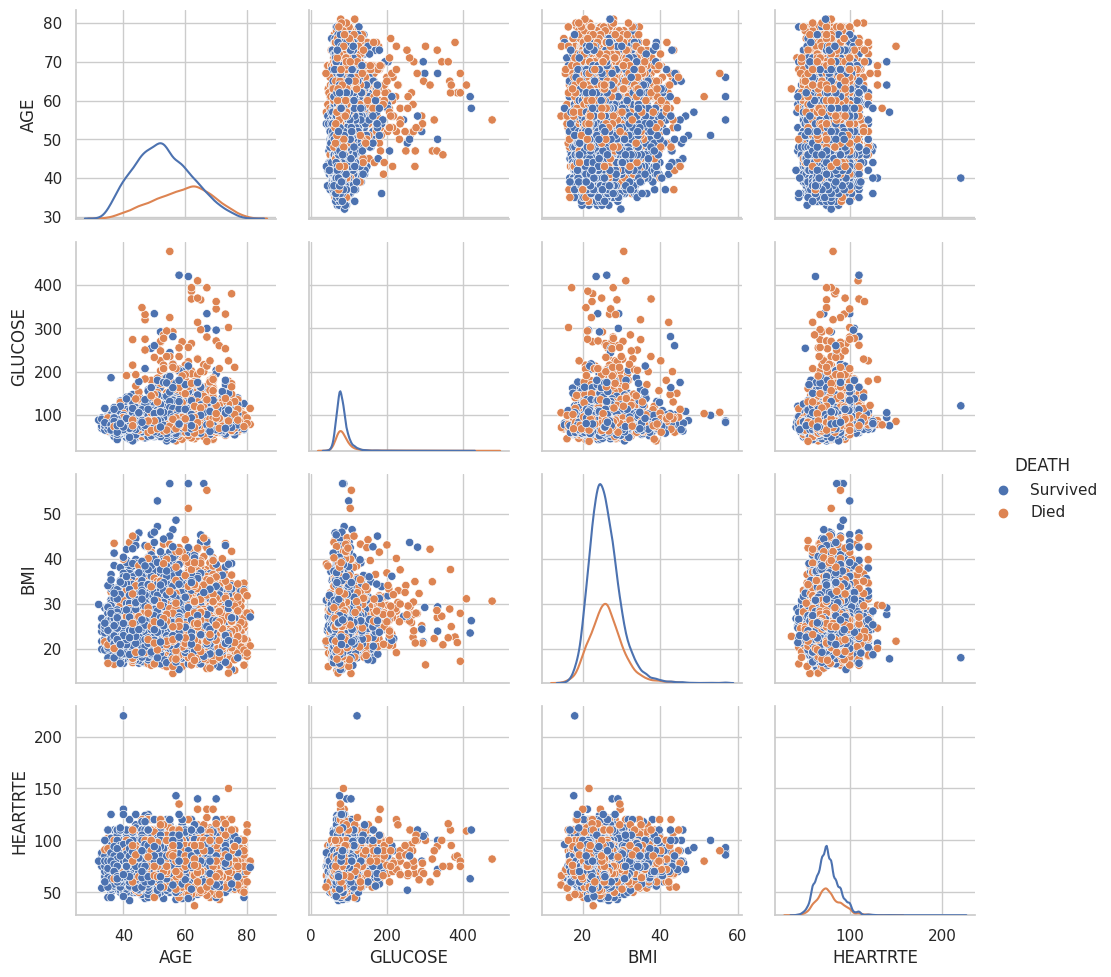

In [25]:
# Plot all graphs on one plot
sns.set(style='whitegrid')
g = sns.PairGrid(hist_df, hue=('DEATH'))
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

There does not appear to be very strong trends between any of the variables. From what is shown, age and heart rate seems to correlate with a higher death count. We can also see that the distribution of people that died is skewed towards older people, implying that age increased the chance of death. The distributions of BMI and glucose show that whether someone lived or died had very little influence from these features. Another notable change is that as age, glucose and BMI increase, there is a slight trend for heart rate to increase. However, it is worth mentioning that the data is very dispersed and there isn't a strong correlation. 

**Diastolic blood pressure and Body Mass Index seem to have a slight correlation. Let's check if theres a relationship.**

<Figure size 1200x400 with 0 Axes>

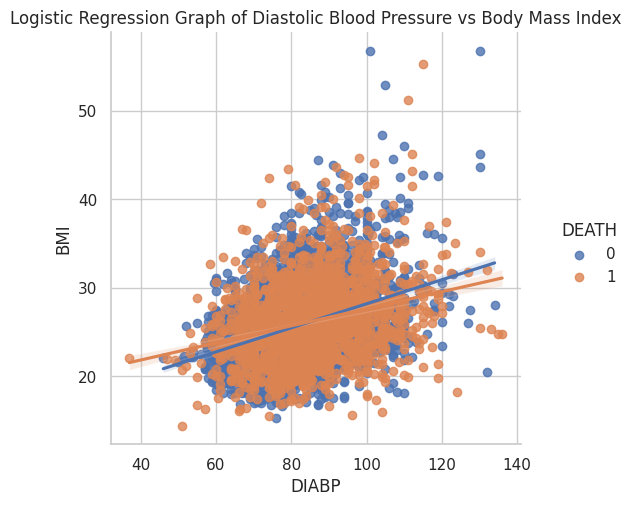

In [26]:
plt.figure()
sns.lmplot(data=train_data, x="DIABP", y="BMI", hue="DEATH")
plt.title("Logistic Regression Graph of Diastolic Blood Pressure vs Body Mass Index")
plt.show()

There seems to be a slight positive trend between Diastolic Blood Pressure and Body Mass Index. The trend is steeper with people who survived versus those who died. We can attribute this to causation: blood pressure increases with a higher Body mass Index (Song et al, 2023).

****

# Hyperparameter Optimisation

Bayesian Hyperparameter Optimisation is the chosen method. It has a few advantages that are worth mentioning. It will not brute force its way through the problem as other methods would. This means that we can still get quality results, efficiently.

### Setup

**Specify the models in a dictionary**

In [27]:
models = {'xgb' : XGBClassifier,
         'rf' : RandomForestClassifier,
         'lr' : LogisticRegression}

**Set up a function to explore possible hyperparameter combinations**

In [28]:
def search_space(model):
    model = model.lower()
    space = {}
    if model == 'xgb':
        space = {
            'eta' : hp.uniform('eta', 0.01, 0.1),
            'max_depth': hp.randint('max_depth', 1, 20),
            'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 0.8),
            'n_estimators' : hp.randint('n_estimators', 100, 1000)
                }
        
    elif model == 'rf':
        space = {'max_depth': hp.randint('max_depth', 1, 20),
    'max_features': hp.randint('max_features', 1, 3),
    'n_estimators': hp.randint('n_estimators', 10, 300),
                }
        
    elif model == 'lr':
        space = {
            'warm_start' : hp.choice('warm_start', [True, False]),
            'fit_intercept' : hp.choice('fit_intercept', [True, False]),
            'tol' : hp.uniform('tol', 0.00001, 0.0001),
            'C' : hp.uniform('C', 0.05, 3),
            'max_iter' : hp.randint('max_iter', 50, 5000),
        }
        
    return space

**We need to impute missing values before tuning**

In [29]:
# Need to impute values before running model
my_imputer = SimpleImputer(strategy='mean')
X_train_final = pd.DataFrame(my_imputer.fit_transform(X_train))
X_train_final.columns = X_train.columns

### XGBoost hyperparameter tuning

Define tuning function

In [30]:
def xgb_cl_bo2(params):
    params = {
            'eta' : params['eta'],
            'max_depth': params['max_depth'],
            'colsample_bytree' : params['colsample_bytree'],
            'n_estimators' : params['n_estimators']
                }
    xgb_bo2 = XGBClassifier(**params)
    best_score = cross_val_score(xgb_bo2, X_train_final, y_train, scoring='accuracy', cv=5).mean()
    return 1 - best_score

Find best parameters

In [31]:
start = time.time()

xgb_best_param = fmin(fn=xgb_cl_bo2,
                     space=search_space('xgb'),
                     max_evals=24,
                     algo=tpe.suggest)
print('It takes %s minutes' % ((time.time() - start)/60))
# Consider using other scoring methods? AUC maybe to be consistent

100%|██████████| 24/24 [01:33<00:00,  3.92s/trial, best loss: 0.20565749235474007]
It takes 1.566734822591146 minutes


In [32]:
print(xgb_best_param)

{'colsample_bytree': 0.6653414931000967, 'eta': 0.047364905791852166, 'max_depth': 2, 'n_estimators': 562}


### Random Forest hyperparameter tuning

Define tuning function

In [33]:
def rf_cl_bo2(params):
    params = {
    'max_depth': params['max_depth'],
    'max_features': params['max_features'],
    'n_estimators': params['n_estimators'],
                }
    
    rf_bo2 = RandomForestClassifier(**params)
    best_score = cross_val_score(rf_bo2, X_train_final, y_train, scoring='accuracy', cv=5).mean()
    return 1 - best_score

Find best parameters

In [34]:
start = time.time()

rf_best_param = fmin(fn=rf_cl_bo2,
                     space=search_space('rf'),
                     max_evals=24,
                     algo=tpe.suggest)
print('It takes %s minutes' % ((time.time() - start)/60))

100%|██████████| 24/24 [01:52<00:00,  4.69s/trial, best loss: 0.21697247706422018]
It takes 1.8776759505271912 minutes


In [35]:
print(rf_best_param)

{'max_depth': 14, 'max_features': 2, 'n_estimators': 115}


### Logistic Regression hyperparameter tuning

We need to scale the data before we can tune

In [36]:
my_scaler = StandardScaler()
scaled_X_train = pd.DataFrame(my_scaler.fit_transform(X_train_final))
scaled_X_train.columns = X_train_final.columns
scaled_X_train.head()

,SEX,TOTCHOL,AGE,DIABP,CIGPDAY,BMI,BPMEDS,HEARTRTE,GLUCOSE,educ,PREVCHD,PREVSTRK,PERIOD,ANYCHD,STROKE,HYPERTEN
0,-1.147826,0.958224,0.551498,1.230690,-0.678570,0.290262,-0.314001,-0.213827,0.547053,0.000000,3.661323,-0.112683,1.358066,1.653141,-0.317529,0.597366
1,0.871212,-0.154595,-0.493950,0.626390,-0.678570,0.850133,-0.314001,-0.535138,0.092160,-0.969601,-0.273125,-0.112683,-1.109430,1.653141,-0.317529,0.597366
2,-1.147826,-1.153861,1.387856,-1.618152,-0.678570,0.043045,-0.314001,-1.338416,0.501563,1.008360,-0.273125,-0.112683,1.358066,-0.604909,-0.317529,-1.674015
3,-1.147826,-0.245437,0.969677,0.453733,-0.678570,-0.553182,3.362601,-1.258089,-0.544691,-0.969601,-0.273125,-0.112683,0.124318,-0.604909,-0.317529,0.597366
4,-1.147826,-0.699649,0.237863,0.281076,1.762913,0.687746,-0.314001,0.669780,-0.408223,0.019380,-0.273125,-0.112683,0.124318,-0.604909,-0.317529,0.597366


Define tuning function

In [37]:
def lr_cl_bo2(params):
    params = {
            'warm_start' : params['warm_start'],
            'fit_intercept' : params['fit_intercept'],
            'tol' : params['tol'],
            'C' : params['C'],
            'max_iter' : params['max_iter'],
                }
    lr_bo2 = LogisticRegression(**params)
    best_score = cross_val_score(lr_bo2, scaled_X_train, y_train, scoring='accuracy', cv=5).mean()
    return 1 - best_score

Find best parameters

In [38]:
start = time.time()

lr_best_param = fmin(fn=lr_cl_bo2,
                     space=search_space('lr'),
                     max_evals=24,
                     algo=tpe.suggest)
print('It takes %s minutes' % ((time.time() - start)/60))

100%|██████████| 24/24 [00:02<00:00,  8.52trial/s, best loss: 0.21345565749235473]
It takes 0.04707855780919393 minutes


In [39]:
print(lr_best_param)

{'C': 0.40637918102841464, 'fit_intercept': 0, 'max_iter': 4445, 'tol': 1.527216142499163e-05, 'warm_start': 0}


We have found the best parameters for each model. It was far faster to compute the logistic regression parameters as opposed to the Random Forest and XGBoost models.

****

# Building Final Models

We're going to build the 3 models and compare them to determine which is the best

**Build XGBoost final model**

In [40]:
# Build preprocessor
num_transformer = SimpleImputer(strategy='most_frequent')
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, X_init.columns)])

# Build model
XGBfinal_model = XGBClassifier(**xgb_best_param)
XGBfinal_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', XGBfinal_model)])

# Fit
XGBfinal_pipeline.fit(X_init, y_init)

# Get Predictions
XGBfinal_preds = XGBfinal_pipeline.predict(X_test)
XGBfinal_predprobs = XGBfinal_pipeline.predict_proba(X_test)[:, 1]

**Build Random Forest final model**

In [41]:
# Use same preprocessor from XGBoost model
# Build model
rffinal_model = RandomForestClassifier(**rf_best_param)
rffinal_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', rffinal_model)])

# Fit
rffinal_pipeline.fit(X_init, y_init)

# Get predictions
rffinal_preds = rffinal_pipeline.predict(X_test)
rffinal_predprobs = rffinal_pipeline.predict_proba(X_test)[:, 1]

**Build Logistic Regression final model**

Preprocessing

In [42]:
# Impute missing values
my_imputer = SimpleImputer(strategy='mean')
X_lr = pd.DataFrame(my_imputer.fit_transform(X_init))
X_lr.columns = X_init.columns

# Create pipeline to scale and create the model
lrfinal_pipeline = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(**lr_best_param))])
lrfinal_pipeline.fit(X_lr, y_init)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.40637918102841464, fit_intercept=0,
                                    max_iter=4445, tol=1.527216142499163e-05,
                                    warm_start=0))])

In [43]:
# Fill in mising values in test data
X_test_lr = pd.DataFrame(my_imputer.fit_transform(X_test))
X_test_lr.columns = X_test.columns

# Get predictions
lrfinal_preds = lrfinal_pipeline.predict(X_test_lr)
lrfinal_predprobs = lrfinal_pipeline.predict_proba(X_test_lr)[:, 1]

****

# Model Analysis and Visualisation

### Model evaluation

**Using ROC curves, we can compare the 3 models and compute their AUC's**

Compute necessary variables to plot ROC-AUC curves

In [44]:
# Determine false positive rates and true positive rates
fpr_XGB, tpr_XGB, thresholdXGB = roc_curve(y_test, XGBfinal_predprobs)
fpr_rf, tpr_rf, thresholdrf = roc_curve(y_test, rffinal_predprobs)
fpr_lr, tpr_lr, thresholdlr = roc_curve(y_test, lrfinal_predprobs)

# Compute Area Under Curve for each ROC
XGB_roc_auc = auc(fpr_XGB, tpr_XGB)
rf_roc_auc = auc(fpr_rf, tpr_rf)
lr_roc_auc = auc(fpr_lr, tpr_lr)

print("XGBoost AUC: ", XGB_roc_auc)
print("Random Forest AUC: ", rf_roc_auc)
print("Logistic Regression: ", lr_roc_auc)
print("-----------------------------------------------------------------")
print("Difference between AUC scores (XGB and RF): ", abs(XGB_roc_auc - rf_roc_auc))
print("Difference between AUC scores (LR and RF): ", abs(rf_roc_auc - lr_roc_auc))
print("Difference between AUC scores (XGB and LR): ", abs(XGB_roc_auc - lr_roc_auc))

XGBoost AUC:  0.8119509640415414
Random Forest AUC:  0.798166668679547
Logistic Regression:  0.8071779675252881
-----------------------------------------------------------------
Difference between AUC scores (XGB and RF):  0.013784295361994436
Difference between AUC scores (LR and RF):  0.009011298845741145
Difference between AUC scores (XGB and LR):  0.004772996516253292


The XGBoost model performs slightly better than the other 2 models. We can see this better using a ROC curve.

**Plot the Receiver Operating Characteristic curves for each model**

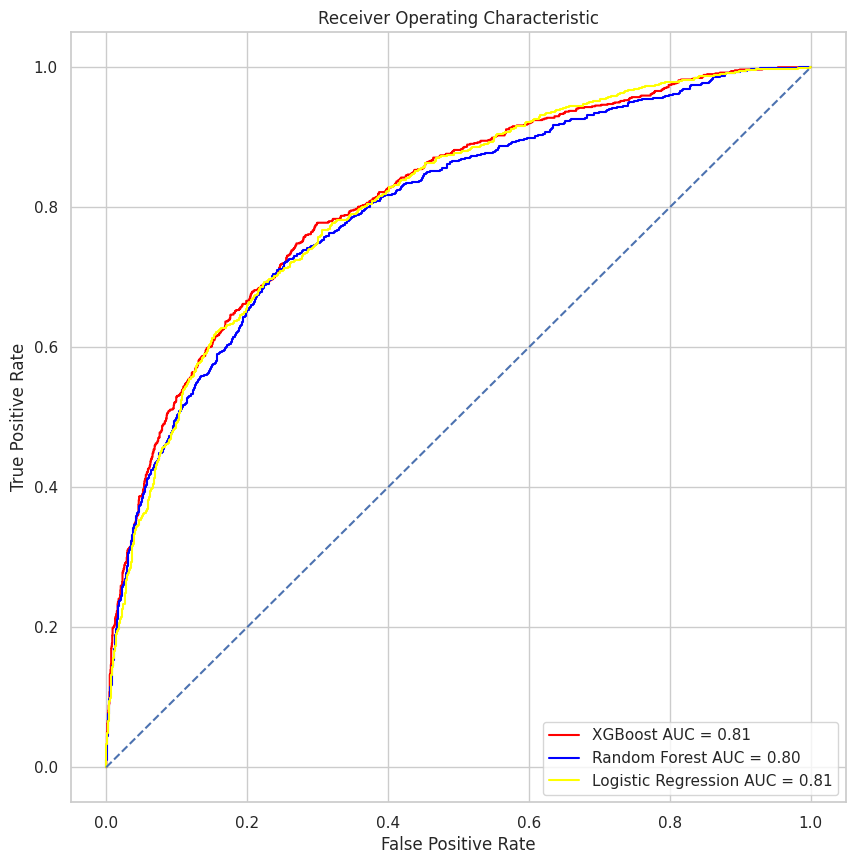

In [45]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_XGB,tpr_XGB, color='red',label = 'XGBoost AUC = %0.2f' % XGB_roc_auc)
plt.plot(fpr_rf,tpr_rf, color='blue',label = 'Random Forest AUC = %0.2f' % rf_roc_auc)
plt.plot(fpr_lr,tpr_lr, color='yellow',label = 'Logistic Regression AUC = %0.2f' % lr_roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Confusion Matrices

**XGB Confusion Matrix**

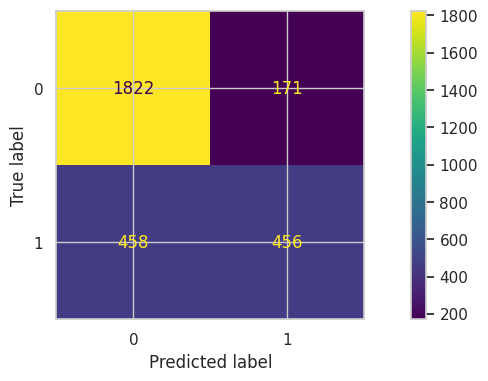

In [46]:
cmXGB = confusion_matrix(y_test, XGBfinal_preds)
dispXGB = ConfusionMatrixDisplay(confusion_matrix=cmXGB)
dispXGB.plot()
plt.show()

**Random Forest Confusion Matrix**

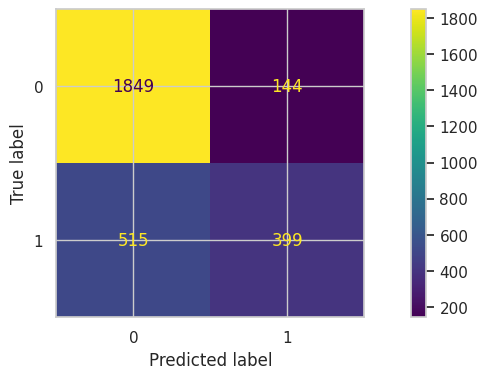

In [47]:
cmrf = confusion_matrix(y_test, rffinal_preds)
disprf = ConfusionMatrixDisplay(confusion_matrix=cmrf)
disprf.plot()
plt.show()

**Logistic Regression Confusion Matrix**

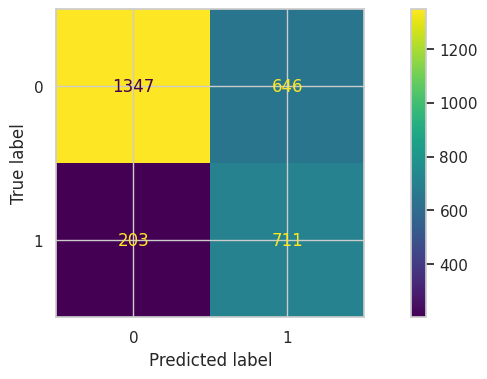

In [48]:
cmlr = confusion_matrix(y_test, lrfinal_preds)
displr = ConfusionMatrixDisplay(confusion_matrix=cmlr)
displr.plot()
plt.show()

The Random Forest and XGBoost models predicted a higher proportion of false negatives as opposed to the Logistic Regression model, which predicted a higher proportion of false positives.

### Feature importance

**SHAPley explanations for XGB Model**

*SHAPley explanations are a game theory approach to determining feature importance and is expressed as the marginal contribution of a feature considering all possible contributions*

*This section was used in conjunction with the correlation plots earlier to eliminate features such that data leakage and data redundancy were avoided*

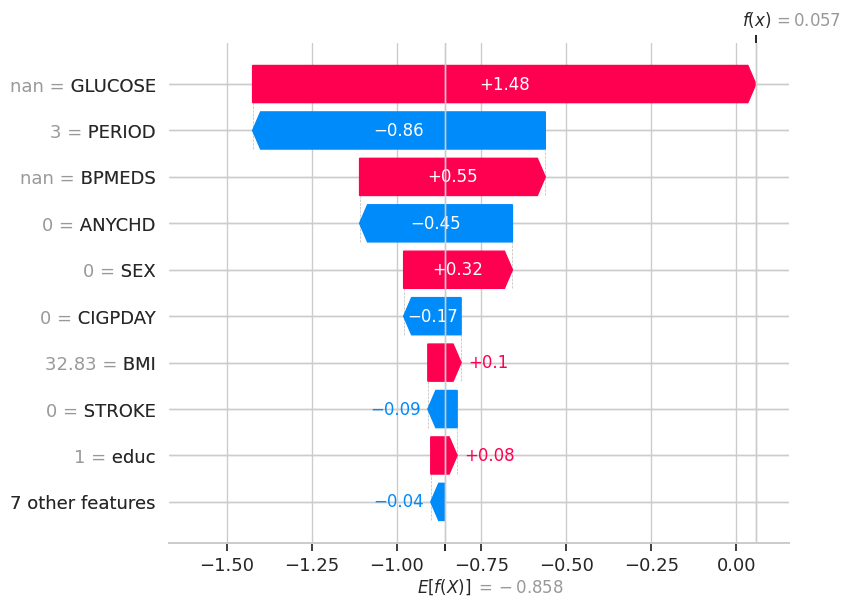

In [49]:
explainer = shap.Explainer(XGBfinal_model)
shap_values = explainer(X_init)

# Visualise how each factor influenced the first prediction
shap.plots.waterfall(shap_values[0])

Age and glucose clearly have the largest feature importance for the first prediction. Let's explore further.

**Summary of all effects of each feature**

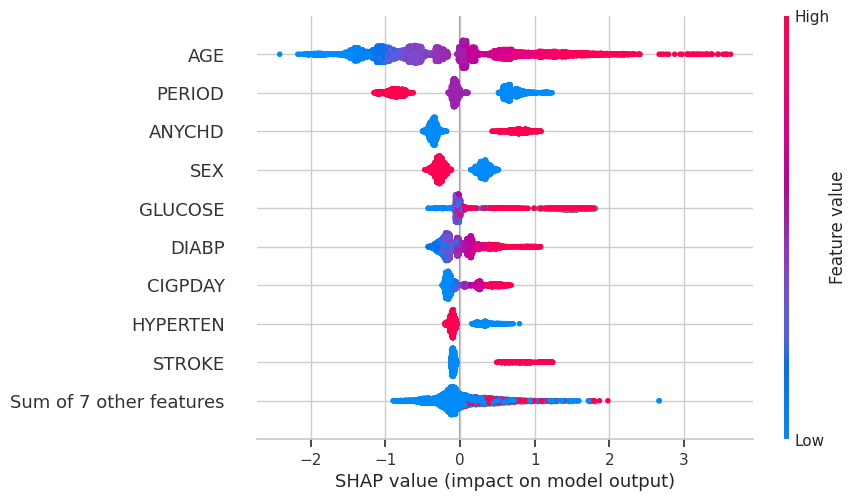

In [50]:
shap.plots.beeswarm(shap_values)

This above visualisation is better in a bar plot

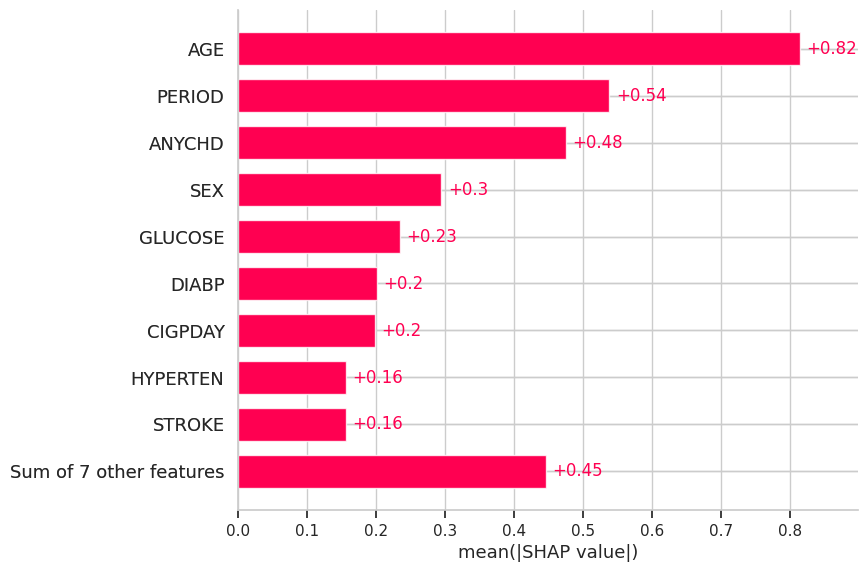

In [51]:
shap.plots.bar(shap_values)

We can see that Age and Period are the most important in determing a prediction

Can evaluate a singular interesting feature and its interaction with another feature

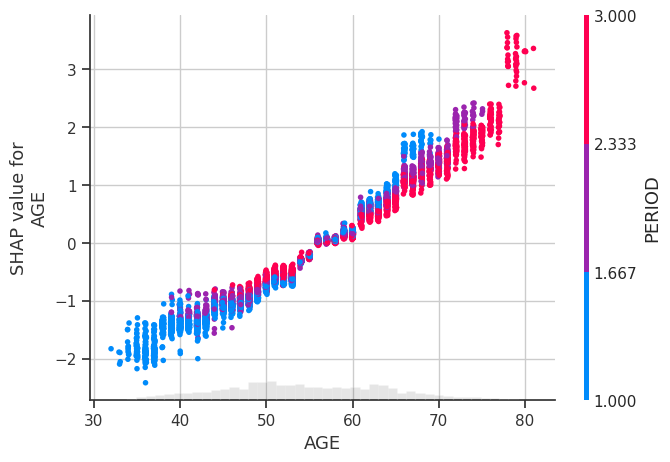

In [52]:
shap.plots.scatter(shap_values[:, "AGE"], color=shap_values)

The interaction with Period and Age is directly proportional.

****

# Analyses and Conclusion

Using the Framingham Heart Study, this project aimed to predict the outcome of a particular patient based on the recorded features. We conducted our exploratory data analysis and found that our target variable had 2 unbalanced classes. We also eliminated features that would result in data leakage or redundancy by using correlation plots. We created 3 models to compare: an XGBoost Classifier, a Random Forest Classifier and a Logistic Regression model. Bayesian Hyperparameter Optimisation was conducted using HyperOpt. Results found that the XGBoost model took the longest to optimise and the logistic regression took the shortest. The XGBoost outperformed both models by a small amount and the Logistic Regression model came second. However, noting that the dataset was not very big and the Logisitic Regression took less time to optimise, we cannot conclude that the XGBoost Classifier was a better model. The SHAPley explanations were conducted on the XGBoost model and it found that Age was the biggest factor that influenced death. In conjunction with period, the occurrence of  Angina Pectoris, Myocardial Infarction, Heart Failure, and Cerebrovascular disease would be a notable factor to consider when prioritising patients. This project could have been improved by adding different models and assessing their effectiveness. Furthermore, a comprehensive review could be conducted to get a better understanding of the features and their interactions. The project could be applied to contemporary fields in numerous ways. We determined which factors affect the possibility of death and thus can focus resources and time into minimising these issues. Furthermore, patients with these issues could be prioritised to reduce their possibility of death.

****

# References

Barla, N. (2024) How to do Model Visualization in machine learning?, neptune.ai. Available at: https://neptune.ai/blog/visualization-in-machine-learning#:~:text=Machine%20learning%20visualization%20(ML%20visualization,through%20graphical%20or%20interactive%20means. (Accessed: 25 May 2024). 

Dataman, C.K. (2023) Explain your model with the shap values, Medium. Available at: https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d (Accessed: 10 June 2024). 

Hyperopt: Distributed asynchronous hyper-parameter optimization (no date) Hyperopt Documentation. Available at: http://hyperopt.github.io/hyperopt/ (Accessed: 25 June 2024). 

Jain, A. (2024) Mastering xgboost parameters tuning: A complete guide with python codes, Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ (Accessed: 25 June 2024). 

Koehrsen, W. (2018) Hyperparameter tuning the random forest in python, Medium. Available at: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 (Accessed: 15 June 2024). 

Labs, D.D. (2017) Parameter tuning with Hyperopt, Medium. Available at: https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce (Accessed: 20 June 2024). 

Shap (no date) Shap/SHAP: A game theoretic approach to explain the output of any machine learning model., GitHub. Available at: https://github.com/shap/shap (Accessed: 25 June 2024). 

The ‘framingham’ data set (no date) R. Available at: https://search.r-project.org/CRAN/refmans/riskCommunicator/html/framingham.html (Accessed: 25 May 2024). 

****